## DS-GA 1011 Lab 8 Neural Attention with Machine Translation

Code adapted from http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html.

In [88]:
%matplotlib inline

In [89]:
from __future__ import unicode_literals, print_function, division
from collections import Counter
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import numpy as np

use_cuda = torch.cuda.is_available()

In [90]:
with open("/Users/carolineroper/Documents/School/Natural Language Processing/Char-NMT/data/train.txt", "r", encoding="utf8") as f:
    
    DE_seq = []
    EN_seq = []
    
    for i, line in enumerate(f):
        
        line = line.split('<JOIN>')
        DE_seq.append(line[0])
        EN_seq.append(line[1])

## Preprocess Data

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [91]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [92]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = s.replace(" <EOS>", "") #there might be other special symbols I need to remove
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s) #separates punctuation from the word
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) #strips anything that isn't a character of punctuation
    return s

In [93]:
def readLangs(seq1, seq2):
    print("Reading lines...")
    
    # Split every line into pairs and normalize
    seq1 = [normalizeString(s) for s in seq1]
    seq2 = [normalizeString(s) for s in seq2]
    pairs = list(map(list, zip(seq1, seq2)))

    return pairs

In [94]:
pairs = readLangs(DE_seq, EN_seq)

input_lang = Lang('ger')
output_lang = Lang('eng')

Reading lines...


Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [96]:
#will ultimately remove this and set MAX_LENGTH to the longest sentence.
MAX_LENGTH = 5

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

pairs = filterPairs(pairs)

In [97]:
len(pairs) 

54

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [98]:
def prepareData(pairs, input_lang, output_lang):
    print("Read %s sentence pairs" % len(pairs))
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return pairs, input_lang, output_lang

pairs, input_lang, output_lang = prepareData(pairs, input_lang, output_lang)


print("total # pairs = {0}".format(len(pairs)))
print("avg # of german sentences = {0}".format(np.mean([len(x[0].split()) for x in pairs])))
print("avg # of english sentences = {0}".format(np.mean([len(x[1].split()) for x in pairs])))
print(random.choice(pairs))

Read 54 sentence pairs
Trimmed to 54 sentence pairs
Counting words...
Counted words:
ger 72
eng 65
total # pairs = 54
avg # of german sentences = 3.8518518518518516
avg # of english sentences = 3.9814814814814814
['sie wurde geschlagen .', 'she s beaten .']


#### Controlling vocab size

In [99]:
vocab_size = 10000

In [100]:
def trim_vocab(list_of_langs, vocab_size):
    for lang in list_of_langs:
        vocab = [count[0] for count in Counter(lang.word2count).most_common(vocab_size)]
        for key in input_lang.word2index.keys():
            if key not in vocab:
                lang.word2index[key] = lang.n_words + 1
        lang.index2word[lang.n_words + 1] = "<UNK>"

In [101]:
trim_vocab(list([input_lang, output_lang]), 10000)

### The Encoder

In [183]:
class EncoderRNN(nn.Module):
    #will set n_layers to 4 to match architecture of Luong's paper
    #but this may also be a hyperparameter we can tune
    def __init__(self, input_size, hidden_size, n_layers):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.embedding_dim = embedding_dim
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        
    def forward(self, x, hidden):
        embedded = self.embedding(x).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, self.hidden = self.lstm(output, hidden)
        return output, hidden
        
    def init_weights(self):
        #is it okay that all the lstm layers share an initialization or do I need to create separate layers
        #for each round of LSTM?
        initrange = 0.1
        lin_layers = [self.linear_f, self.linear_i, self.linear_ctilde, self.linear_o]
        em_layer = [self.embedding]
     
        for layer in lin_layers+em_layer:
            layer.weight.data.uniform_(-initrange, initrange)
            if layer in lin_layers:
                layer.bias.data.fill_(0)

    def initHidden(self):
        #the paper says to use "uniform initialization of parameters in [−0.1,0.1]: does that include these?"
        h0 = Variable(torch.zeros(1, 1, self.hidden_size))
        c0 = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return h0.cuda(), c0.cuda()
        else:
            return h0, c0

### Attention Decoder

In [245]:
class AttnDecoderRNN(nn.Module):
    #will ultimately set max_length based on the maximum length of a sequence found in our data
    #changed dropout to .2 based on Zaremba paper
    
    #should there be more than one hidden?
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.2, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn_1 = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine_1 = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn_2 = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine_2 = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_output, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        cat = torch.cat((embedded[0], hidden[0][0]), 1)
        
        #first attention mechanism for the sake of the word-level model
        #this was a softmax originally, replaced with tanh as paper describes
        #but the actual attention mechanism may be different
        attn_weights_1 = F.tanh(
            self.attn_1(torch.cat((embedded[0], hidden[0][0]), 1)))
        attn_applied_1 = torch.bmm(attn_weights_1.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        #the paper doesn't explicitly mention these layers
        #but I think this is necessary in general for 
        #an attentional decoder
        output_1 = torch.cat((embedded[0], attn_applied_1[0]), 1)
        output_1 = self.attn_combine_1(output_1).unsqueeze(0)
        
        #second attention mechanism for the sake of the character-level model
        
        attn_weights_2 = F.tanh(
            self.attn_2(torch.cat((embedded[0], hidden[0][0]), 1)))
        attn_applied_2 = torch.bmm(attn_weights_2.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        output_2 = torch.cat((embedded[0], attn_applied_2[0]), 1)
        output_2 = self.attn_combine_2(output_2).unsqueeze(0)

        output_1 = F.log_softmax(self.out(output_1[0]))
        return output_1, hidden, attn_weights_1
    
    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

## Training

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [196]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result

def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [247]:
def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
   
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden

    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_output, encoder_outputs)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        loss += criterion(decoder_output, target_variable[di])
        if ni == EOS_token:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [248]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [249]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]
 
        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [230]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [ ]:
#MAX_LENGTH = 2836

In [250]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    @output decoder_attentions: a list of vector, each of which sums up to 1.0
    """
    # process input sentence
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    # encode the source lanugage
    encoder_hidden = encoder.initHidden()
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]
    
    # decode the context vector
    decoder_hidden = encoder_hidden # decoder starts from the last encoding sentence
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    # output of this function
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    # unfold
    for di in range(max_length):
        # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
        #error here
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_output, encoder_outputs)
        # hint: print out decoder_output and decoder_attention
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        # stop unfolding whenever '<EOS>' token is returned
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
        
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [232]:
def evaluateRandomly(encoder, decoder, n=10):
    """
    Randomly select a English sentence from the dataset and try to produce its German translation.
    Note that you need a correct implementation of evaluate() in order to make this function work.
    """
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training

   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.

In [ ]:
#trying the tip about commenting out the init lines

1m 37s (- 46m 58s) (1000 3%) 1.6434
3m 9s (- 44m 13s) (2000 6%) 1.4737
4m 32s (- 40m 49s) (3000 10%) 1.4855
5m 46s (- 37m 29s) (4000 13%) 1.5011
7m 4s (- 35m 22s) (5000 16%) 1.4545
8m 25s (- 33m 41s) (6000 20%) 1.4947
9m 45s (- 32m 4s) (7000 23%) 1.4847
11m 4s (- 30m 28s) (8000 26%) 1.5031
12m 32s (- 29m 15s) (9000 30%) 1.4840
14m 10s (- 28m 21s) (10000 33%) 1.4570
15m 39s (- 27m 2s) (11000 36%) 1.4454
17m 9s (- 25m 43s) (12000 40%) 1.4704
18m 31s (- 24m 13s) (13000 43%) 1.4362
19m 55s (- 22m 46s) (14000 46%) 1.4421
21m 17s (- 21m 17s) (15000 50%) 1.3763
22m 49s (- 19m 58s) (16000 53%) 1.2815
24m 13s (- 18m 31s) (17000 56%) 1.0741
25m 31s (- 17m 0s) (18000 60%) 0.9571
27m 3s (- 15m 39s) (19000 63%) 0.8719
28m 44s (- 14m 22s) (20000 66%) 0.8363
30m 13s (- 12m 57s) (21000 70%) 0.9069
31m 28s (- 11m 26s) (22000 73%) 0.7329
32m 46s (- 9m 58s) (23000 76%) 0.7576
34m 9s (- 8m 32s) (24000 80%) 0.5649
35m 44s (- 7m 8s) (25000 83%) 0.6002
37m 19s (- 5m 44s) (26000 86%) 0.5531
38m 44s (- 4m 18s)

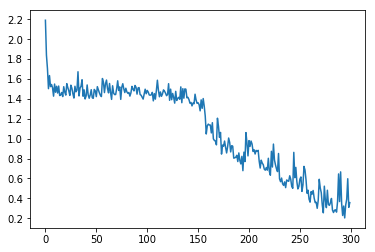

In [255]:
hidden_size = 256
###the paper says to use 1024-dimensional embeddings, so I guess the hidden size is 1024
###6-epoch training with plain SGD and a simple learn-ing rate schedule – 
#start with a learning rate of 1.0; after 4 epochs, halve the learning rate every 0.5 epoch
#how do we change the learning rate schedule and do I need to start an epoch counter?
#it also says the batch size of 128, although I would say that this model currently
#doesn't have a batch size or has a batch size of 1.
n_layers = 4


#not sure about n_words, could be vocab size.

encoder1 = EncoderRNN(vocab_size, hidden_size, 4)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               1, dropout_p=0.2)

if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

trainIters(encoder1, attn_decoder1, 30000, print_every=1000) #75000 is the number of iterations, could recode this

torch.save(encoder1.state_dict(), "saved_encoder_3.pth")
torch.save(attn_decoder1.state_dict(), "saved_decoder_3.pth")

#encoder1.load_state_dict(torch.load("saved_encoder.pth"))
#attn_decoder1.load_state_dict(torch.load("saved_decoder.pth"))

In [258]:
output_lang.word2index

{'!': 66,
 '.': 5,
 'ab': 66,
 'am': 12,
 'and': 15,
 'ansteckend': 66,
 'are': 3,
 'auftragsarbeiten': 66,
 'beaten': 36,
 'besorgt': 66,
 'bewegen': 66,
 'biased': 55,
 'bin': 66,
 'chocolates': 62,
 'christen': 66,
 'christians': 20,
 'clever': 66,
 'colorblind': 64,
 'commissioned': 63,
 'critical': 17,
 'crushed': 4,
 'curious': 22,
 'delicacies': 38,
 'delicious': 46,
 'delikatessen': 66,
 'die': 66,
 'domestics': 48,
 'drei': 66,
 'dynamic': 56,
 'dynamisch': 66,
 'eins': 66,
 'entschuldigung': 66,
 'er': 66,
 'erregend': 66,
 'es': 66,
 'everywhere': 10,
 'excitatory': 41,
 'extrapolating': 31,
 'falsch': 66,
 'farbenblind': 66,
 'gelahmt': 66,
 'geschlagen': 66,
 'haben': 66,
 'hausangestellte': 66,
 'he': 39,
 'here': 52,
 'hier': 66,
 'i': 11,
 'ich': 66,
 'in': 35,
 'infectious': 32,
 'interesse': 66,
 'interessiert': 66,
 'interested': 19,
 'is': 27,
 'ist': 66,
 'jetzt': 66,
 'joking': 42,
 'kidding': 51,
 'kritisch': 66,
 'lecker': 66,
 'leite': 66,
 'liegen': 66,
 'live

In [257]:
input_lang.word2index

{'!': 35,
 '.': 5,
 'ab': 32,
 'ansteckend': 33,
 'auftragsarbeiten': 70,
 'besorgt': 21,
 'bewegen': 29,
 'bin': 11,
 'christen': 18,
 'clever': 56,
 'delikatessen': 43,
 'die': 51,
 'drei': 16,
 'dynamisch': 61,
 'eins': 49,
 'entschuldigung': 62,
 'er': 44,
 'erregend': 46,
 'es': 69,
 'falsch': 23,
 'farbenblind': 71,
 'gelahmt': 55,
 'geschlagen': 39,
 'haben': 25,
 'hausangestellte': 54,
 'hier': 57,
 'ich': 10,
 'in': 37,
 'interesse': 42,
 'interessiert': 17,
 'ist': 6,
 'jetzt': 27,
 'kritisch': 15,
 'lecker': 52,
 'leite': 31,
 'liegen': 22,
 'live': 34,
 'nackt': 7,
 'neugierig': 20,
 'perfekt': 24,
 'produktiv': 12,
 'psychiaterinnen': 58,
 'rekonstruktiv': 59,
 'saugetiere': 53,
 'schaut': 40,
 'scherze': 47,
 'schluchzt': 45,
 'schockiert': 19,
 'schokolade': 68,
 'sie': 2,
 'sind': 8,
 'singen': 66,
 'staatenlos': 65,
 'stark': 50,
 'trage': 63,
 'uberall': 9,
 'und': 14,
 'unrecht': 26,
 'uns': 30,
 'unterdruckt': 13,
 'veraltet': 48,
 'verantwortung': 64,
 'verkauft': 

In [256]:
evaluateRandomly(encoder1, attn_decoder1)

> sie sind neugierig .
= they are curious .
< they are curious . <EOS>

> wir sind eins .
= we are one .
< we are one . <EOS>

> ich trage verantwortung .
= i m responsible .
< i m responsible . <EOS>

> sie sind staatenlos .
= they are stateless .
< they are stateless . <EOS>

> ich bin interessiert .
= i m interested .
< i m biased . <EOS>

> ich bin stark .
= i m powerful .
< i m colorblind . <EOS>

> sie sind drei .
= they re three .
< they re three . <EOS>

> sie sind live !
= you re live .
< you re wrong . <EOS>

> es sind auftragsarbeiten .
= they are commissioned .
< they are commissioned . <EOS>

> sie sind und .
= they re and .
< they re dynamic . <EOS>

